## Task 3: Image classification

### Inhoud
* Inleiding
* Uitvoering
* Gebruik van GenAI tools
* Streamlit link
* Conclusie

### Inleiding

Voor deze opdracht was het de bedoeling om een neuraal netwerk te maken waarmee je minstens 5 verschillende categoriën kan categoriseren. Hiervoor moesten we een web scraper, een neuraal netwerk en een Streamlit applicatie voorzien. Voor dit project heb ik gekozen om verschillende hondenrassen te categoriseren, want wie houdt er nu niet van honden?

### Uitvoering

Het eerste wat moest gebeuren, was een web scraper maken. Hieraan wou ik niet teveel tijd verspillen, dus heb ik hulp gevraagd aan een GenAI tool. Dit heb ik aan de tool gevraagd: "Could you give me a Python web scraper using Selenium to fetch images of different animals from Google Images, and organize them into training and testing sets".

Hiervan kreeg ik een degelijke webscraper die ik zelf nog wat heb bijgeschaafd om tot een goede versie te komen voor het project. Zo heb ik het onder andere nog aangepast om de zoektermen uit een lijst te halen en de juiste mappen te gebruiken, voor de rest verliep dit deel redelijk vlot.

Hieronder vindt u de code terug.

In [2]:
from selenium import webdriver
from selenium import webdriver
import os
import time
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import urllib.request
import random
import numpy as np

# start de webdriver
browser = webdriver.Chrome()
# ga naar Google images
browser.get('https://images.google.com/')

# klik op de cookies popup
cookies = browser.find_element(By.ID,"L2AGLb")
cookies.click()
time.sleep(2)


# Functie om hondenfoto's te zoeken en te downloaden
def findDogs(dog):
    browser.get('https://images.google.com/')

    # geef de zoekterm in
    query = browser.find_element(By.NAME,'q')
    query.send_keys(dog + " pictures")
    query.submit()

    # scroll verder om meer afbeeldingen te laden
    for i in range(15):
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

    # Neem de URL's van de afbeeldingen
    for picture in browser.find_elements(By.XPATH,'//img[contains(@class,"rg_i")]'):
        pictures.append(picture.get_attribute('src'))


# Zoektermen
dogs = ['malinois', 'labrador', 'corgi', 'doberman', 'beagle']


# Loop over de zoektermen
for dog in dogs:
    pictures = []
    findDogs(dog)

    # Check of de folders al bestaan, er wordt meteen een training en een testing folder gemaakt
    # Als ze nog niet bestaan worden ze aangemaakt
    if not os.path.exists('C:/3TI/AI/data/newdata/training_set/'+dog):
            os.makedirs('C:/3TI/AI/data/newdata/training_set/'+dog)
    if not os.path.exists('C:/3TI/AI/data/newdata/testing_set/'+dog):
            os.makedirs('C:/3TI/AI/data/newdata/testing_set/'+dog)

    i=0

    # Shuffle de foto's
    np.random.shuffle(pictures)

    # Loop over alle URL's
    for picture in pictures:
        # We gebruiken 20% van de foto's voor de validatieset, en de andere 80% voor de trainingset
        if i<=int(len(pictures) * 0.2):
            try:
                urllib.request.urlretrieve(picture, f"C:/3TI/AI/data/newdata/testing_set/{dog}/{dog}{i}.jpg")
            except:
                x = 0
        else:
            try:
                urllib.request.urlretrieve(picture, f"C:/3TI/AI/data/newdata/training_set/{dog}/{dog}{i}.jpg")
            except:
                x = 0
        i+=1

# Sluit de browser
browser.quit()

Na de scraper heb ik eerst de data verzameld, vanaf dit deel heb ik vooral de cursus gevolgd. Ik heb wel overal rekening gehouden dat dit model meer dan 2 categoriën heeft, en het daarvoor aangepast naar categorical. 

Voor de data te verzamelen heb ik gekozen voor de manier zonder DataLoaders. Dit verliep eigenlijk van een leien dakje, enkel heb ik nog wat gespeeld met de batch size, maar uiteindelijk toch gekozen om het op 32 te houden. 

Hieronder kan u de imports en de code hiervoor terugvinden.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


In [4]:
# Set the parameters for your data
batch_size = 32
image_size = (64, 64)
validation_split = 0.2

# Create the training dataset from the 'train' directory
train_ds = image_dataset_from_directory(
    directory='C:/3TI/AI/data/training_set',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Create the validation dataset from the 'train' directory
validation_ds = image_dataset_from_directory(
    directory='C:/3TI/AI/data/training_set',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Create the testing dataset from the 'test' directory
test_ds = image_dataset_from_directory(
    directory='C:/3TI/AI/data/testing_set',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size
)



Found 870 files belonging to 5 classes.
Using 696 files for training.
Found 870 files belonging to 5 classes.
Using 174 files for validation.
Found 221 files belonging to 5 classes.


Vervolgens heb ik het model gemaakt en daarin data augmentation en preprocessing toegepast. Ook hier heb ik de cursus voor een groot deel gevolgd, maar weer aanpassingen gemaakt zodat het klopte voor een model met vijf categoriën.
Daarvoor heb ik de instellingen aangepast naar categorical en heb ik voor Softmax gekozen als activatiefunctie op mijn laatste laag.

In dit deel heb ik het meeste geëxperimenteerd met verschillende instellingen om mijn model te verbeteren. Meer en minder lagen, drop-out instellen en wat mee testen, batch normalisation, learning rate etc.
Hieruit heb ik geconcludeerd dat teveel lagen niet werkten voor mijn model, en dat de learning rate het meeste invloed leek te hebben. Natuurlijk zijn de drop-out en het aantal lagen ook belangrijk, maar dit leek in dit geval minder verschil te maken.

Hieronder kan u de code voor het model terugvinden.

In [5]:
NUM_CLASSES = 5 # aantal klassen (hondenrassen)
IMG_SIZE = 64
HEIGHT_FACTOR = 0.2
WIDTH_FACTOR = 0.2


# Model aanmaken
model = tf.keras.Sequential([
    # wat data augmentation
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(HEIGHT_FACTOR, WIDTH_FACTOR),
    layers.RandomZoom(0.2),

    # Convolutional layers met 32 filters, activation relu en een aangepaste padding
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    # Max pooling om de images te verkleinen
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    # Maakt de data 1-dimensionaal
    layers.Flatten(),

    # Dense layer met 256 neuronen
    layers.Dense(256, activation="relu"),

    # dropout om overfitting te voorkomen
    layers.Dropout(0.5),

    # Dense layer met het aantal klassen die we nodig hebben, en softmax voor de activatie
    layers.Dense(NUM_CLASSES, activation="softmax")
])

# Compileert het model en maakt het model en gebruikt adam als optimizer. Ook kan je hier de learning rate aanpassen.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

Nadat het model is gemaakt moet het getraind worden. Hier heb ik ook wat aanpassingen gemaakt. Zo houdt het in het oog of de loss niet terug teveel stijgt tijdens het trainen, waarna het automatisch stopt. Hiermee heb ik wat getest. 

Ook met het aantal epochs heb ik wat uitgeprobeerd, maar uiteindelijk heb ik voor 100 gekozen omdat dit meestal een accuraat model geeft, en het indien nodig toch automatisch wordt gestopt.

In [6]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6) # lagere patience stopt het model sneller
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    steps_per_epoch=len(train_ds), # aantal stappen obv de dataset
    validation_steps=len(validation_ds), # aantal stappen obv de dataset
    epochs=100,
    callbacks=[callback] # callback voor vroegtijdige stopzetting
)


Epoch 1/100


22/22 [==============================] - 3s 58ms/step - loss: 1.6427 - accuracy: 0.1782 - val_loss: 1.6105 - val_accuracy: 0.1552
Epoch 2/100
22/22 [==============================] - 1s 53ms/step - loss: 1.6088 - accuracy: 0.1940 - val_loss: 1.6045 - val_accuracy: 0.2759
Epoch 3/100
22/22 [==============================] - 1s 51ms/step - loss: 1.6081 - accuracy: 0.2155 - val_loss: 1.6038 - val_accuracy: 0.3103
Epoch 4/100
22/22 [==============================] - 1s 52ms/step - loss: 1.5970 - accuracy: 0.2213 - val_loss: 1.6014 - val_accuracy: 0.2759
Epoch 5/100
22/22 [==============================] - 1s 54ms/step - loss: 1.5962 - accuracy: 0.2284 - val_loss: 1.5724 - val_accuracy: 0.2759
Epoch 6/100
22/22 [==============================] - 1s 50ms/step - loss: 1.5720 - accuracy: 0.2787 - val_loss: 1.5227 - val_accuracy: 0.3333
Epoch 7/100
22/22 [==============================] - 1s 54ms/step - loss: 1.5502 - accuracy: 0.3075 - val_loss: 1.5725 - val_accuracy: 0.3506
Epoc

Tot slot heb ik de resultaten gevisualiseerd en vergeleken met Google's Teachable Machine. 

Voor de grafieken en het resultaat heb ik code uit onze cursus gebruikt, en voor de confusion matrix heb ik gebruik gemaakt van een GenAI tool.

Zoals u kan zien haalt mijn model ongeveer 50% accuracy. Niet fantastisch hoog, maar na veel met instellingen te spelen leek me dit het hoogst haalbare. Ik ben me ervan bewust dat er manieren zullen zijn om nog meer uit dit model te halen zonder transfer learning, maar die manieren heb ik niet kunnen vinden.

Hoewel 50% accuracy niet zo hoog is, ben ik wel blij met het resultaat. In het begin kwam het model maar aan een 20%, dus nu weet het al meer dan dubbel zoveel keer juist te antwoorden. 
Toch een aanzienlijk verschil.

Voor de AI van Google is dit echter peanuts, waardoor dat resultaat nog zo'n 40% accurater is dan mijn model.

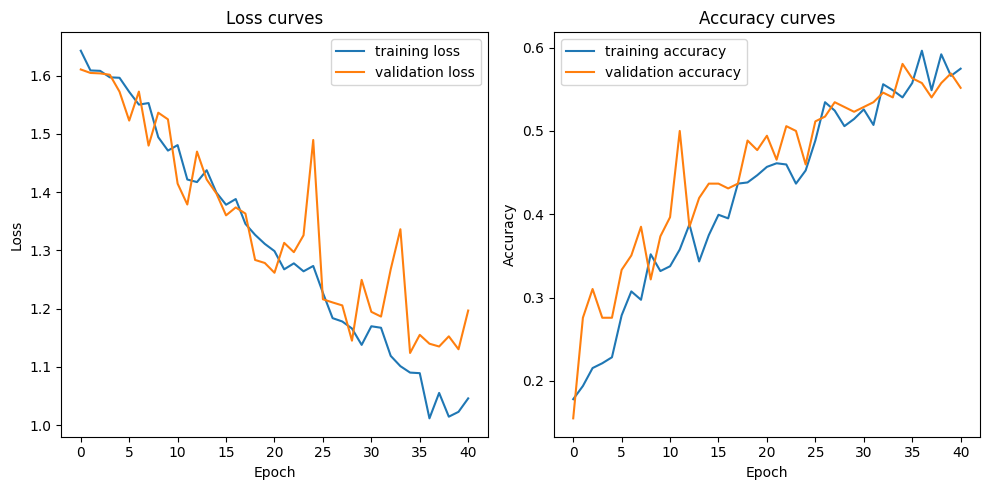

In [7]:
# Create a figure and a grid of subplots with a single call
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the loss curves on the first subplot
ax1.plot(history.history['loss'], label='training loss')
ax1.plot(history.history['val_loss'], label='validation loss')
ax1.set_title('Loss curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the accuracy curves on the second subplot
ax2.plot(history.history['accuracy'], label='training accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
ax2.set_title('Accuracy curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

In [8]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

7/7 [==============================] - 0s 11ms/step - loss: 1.2720 - accuracy: 0.5158
Test accuracy: 0.5158371329307556


#### Confusion matrices

##### Van mezelf

7/7 [==============================] - 0s 12ms/step


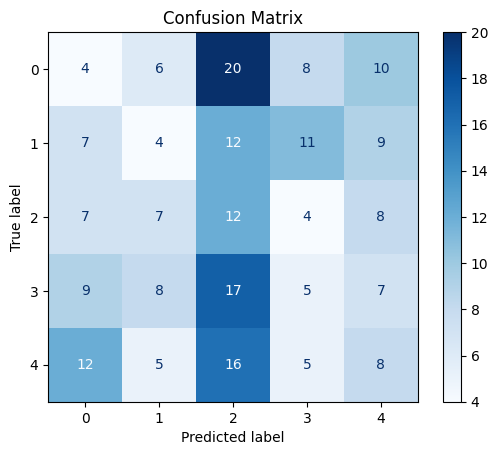

In [9]:
# Evaluate the model on the test dataset
predictions = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Convert the one-hot encoded labels to class indices
y_true_indices = np.argmax(y_true, axis=1)
predictions_indices = np.argmax(predictions, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_indices, predictions_indices, labels=range(NUM_CLASSES))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(NUM_CLASSES))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

##### Van Google
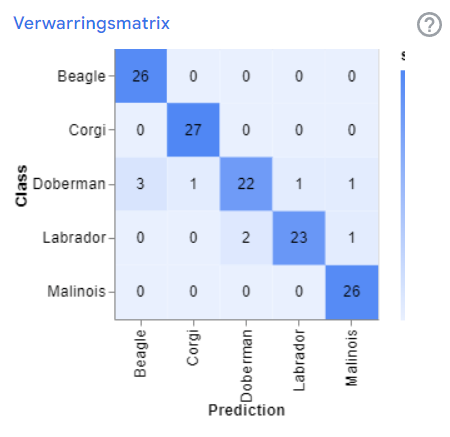


### Gebruik van GenAI tools

Voor deze taak heb ik af en toe gebruik gemaakt van GenAI tools. Onder andere voor de scraper, wat hulp bij het maken van het model, voor het creëren van de confusion matrix, en ten slotte om de Streamlit applicatie te maken.

Hieronder vindt u mijn prompts terug.

Web scraper:

&nbsp;&nbsp;&nbsp;&nbsp;Could you give me a Python web scraper using Selenium to fetch images of different animals from Google Images, and organize them into training and testing sets

Omvormen model voor 5 categorieën:

&nbsp;&nbsp;&nbsp;&nbsp;If I have 5 things the algorithm needs to differentiate, how do I edit this so it works correctly? 
`NUM_CLASSES = 1
...
print(model.summary())`

Decision matrix:

&nbsp;&nbsp;&nbsp;&nbsp;How do I plot the decision matrix for this? `NUM_CLASSES = 5 ...  callbacks=[callback])`

Streamlit app:

&nbsp;&nbsp;&nbsp;&nbsp;Create a streamlit app for this code: `Mijn code`

Bij dit heb ik nog enkele aanpassingen gevraagd, zoals bv. "Give me a slider to adjust de learning rate"




### Streamlit link

https://deep-learning-matthias-verstappen.streamlit.app

### Conclusie

Ik vond het een interessante opdracht, en het was leuk om eens mee te werken omdat het geen exacte wetenschap is. Je kan wat spelen met instellingen, wat soms weliswaar voor frustraties kan zorgen, maar wat er ook voor zorgt dat je wat je ding kan doen om te zien hoe alles in elkaar zit.

In zijn geheel was het een interessante en leuke kennismaking met deep learning.
